# Sales Quantity Forecasting

## 1. Introduction

written by Franciscus Andrew Sunanda

in this project, I will try to analyze timeseries dataset in Sales Quantity

the objective is to create a model that can forecast / predict future sales

## 2. External Link

Presentation = [Link](https://drive.google.com/file/d/1KdL2qNsfqxN_A2TbnVKjkQQIx0iep4Cr/view?usp=sharing)

## 3. Working Area

### 3.1 Import Libraries

In [179]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

### 3.2 Data Loading

In [180]:
# Load Data CSV ke dalam variabel df
df = pd.read_csv('sample_dataset_timeseries_noarea.csv')
df.head(10)

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119
5,2021-52,2021-12-27,2022-01-02,01fa9977e1c61ce5542c6f0c2a1b2895,2
6,2021-52,2021-12-27,2022-01-02,043e6d02d98b44c40645c8a22812fe88,44
7,2021-52,2021-12-27,2022-01-02,0512efdcc99fa4d57c42cd2cf6c73633,165
8,2021-52,2021-12-27,2022-01-02,05262da388ab82c51c48c9535bc8b121,41
9,2021-52,2021-12-27,2022-01-02,058cc2cecb91d10e901a597e67532619,383


In [181]:
# Tampilkan informasi general mengenai isi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


Berikut ini adalah list column yang ada dalam dataset in:

Header | Definition
---|---
`week_number` | Week of specific product sold
`week_start_date` | Week start date of specific product sold
`week_end_date` | Week end date of specific product sold
`product_item` | Product Item / Product Code
`quantity` | Quantity of product sold in respective week

### 3.3 Exploratory Data Analysis (EDA)

In [182]:
# Make data variabel with only week_start_date and quantity column because I simply think that the other columns is irrelevant
data = df[['week_start_date', 'quantity']]
data

,week_start_date,quantity
0,2021-12-27,41
1,2021-12-27,430
2,2021-12-27,4
3,2021-12-27,148
4,2021-12-27,119
...,...,...
102728,2023-04-03,907
102729,2023-04-03,81
102730,2023-04-03,16
102731,2023-04-03,42920


In [183]:
# convert the week_start_date column to a datetime column
data['week_start_date'] = pd.to_datetime(data['week_start_date'])

In [184]:
data.week_start_date.describe()

count                  102733
unique                     67
top       2022-08-01 00:00:00
freq                     1831
first     2021-12-27 00:00:00
last      2023-04-03 00:00:00
Name: week_start_date, dtype: object

Isi dataset ini berarti mulai dari minggu terakhir di tahun 2021 sampai minggu pertama di bulan April 2023

In [185]:
# ggroup by sales quantity based on weekly sales
weekly = data.groupby('week_start_date').sum()
weekly

,quantity
week_start_date,
2021-12-27,128808
2022-01-03,3839557
2022-01-10,4138934
2022-01-17,4149077
2022-01-24,4824273
...,...
2023-03-06,4775638
2023-03-13,4787111
2023-03-20,4757590


In [186]:
mean_quantity = data['quantity'].mean()
std_quantity = data['quantity'].std()

print('Mean quantity: {}'.format(mean_quantity))
print('Standard deviation of quantity: {}'.format(std_quantity))

Mean quantity: 3191.5624190863696
Standard deviation of quantity: 12074.631013973585


In [187]:
weekly = weekly.asfreq('W-Mon')
weekly

,quantity
week_start_date,
2021-12-27,128808
2022-01-03,3839557
2022-01-10,4138934
2022-01-17,4149077
2022-01-24,4824273
...,...
2023-03-06,4775638
2023-03-13,4787111
2023-03-20,4757590


In [188]:
weekly.isna().sum()

quantity    0
dtype: int64

In [189]:
fig = px.line(weekly, x=weekly.index, y='quantity', title='Weekly Sales Quantity')
fig.show()

Sesuai plot diatas, bisa kita lihat quantity sales selalu naik turun tapi umum nya di jumlah yang berdekatan. Terjadi nya penurunan yang besar di sekitar awal May 2022. Saya asumsi ini disebabkan libur lebaran 2022, dimana sedang cuti bersama sehingga menurunkan transaksi yang terjadi. Sedangkan minggu setelah nya langsung mencetak record tertinggi penjualan dalam seminggu, mungkin juga disebabkan setelah lebaran, para konsumer mendapat THR sehingga banyak yang langsung berbelanja produk kita

In [190]:
quarterly = data.resample('Q', on='week_start_date').sum()
fig = px.line(quarterly, x=quarterly.index, y='quantity', title='Quarterly Sales Quantity')
fig.show()

Kalau saya ubah data nya berdasarkan quarterly, cukup stabil pergerakan nya namun memasuki Q4 2022 dan Q1 2023 mengalami penurunan. (Q2 2023 bisa di ignore dulu karena baru ter record 1 minggu penjualan)

In [191]:
product = df.groupby('product_item')['quantity'].sum().sort_values(ascending=False).head(10)
# Create bar plot
fig = px.bar(product, x=product.index, y='quantity', labels={'x': 'Product', 'quantity': 'Quantity'})
fig.show()

Sales kita di dominasi salah satu product. Top product kita terjual 2x lipat dari product nomor 2

### 3.4 Forecasting

In [192]:
# Splitting the data to train set and test set
size = int(len(weekly)*0.8)
train = weekly.iloc[:size]
test = weekly.iloc[size:]

In [193]:
train.head(2)

,quantity
week_start_date,
2021-12-27,128808
2022-01-03,3839557


In [194]:
# Saya ignore data minggu terakhir 2021 karena angka nya yang berbeda sangat jauh dengan yang lain
train = train[1:]
train.head(2)


,quantity
week_start_date,
2022-01-03,3839557
2022-01-10,4138934


In [195]:
train.tail()

,quantity
week_start_date,
2022-11-28,4953197
2022-12-05,5717901
2022-12-12,5259200
2022-12-19,5768419
2022-12-26,4677997


In [196]:
test.head()

,quantity
week_start_date,
2023-01-02,4111427
2023-01-09,4623965
2023-01-16,5265632
2023-01-23,4364421
2023-01-30,4703388


In [197]:
# Checking White Noise
wn = np.random.normal(loc = train.quantity.mean(), scale = train.quantity.std(), size = len(train))
train['wn'] = wn
train.describe()

,quantity,wn
count,5.200000e+01,5.200000e+01
mean,5.072189e+06,5.212614e+06
std,9.029212e+05,8.384848e+05
min,1.334134e+06,3.728638e+06
25%,4.603696e+06,4.612514e+06
50%,5.141238e+06,5.239816e+06
75%,5.728350e+06,5.956163e+06
max,7.172144e+06,6.794033e+06


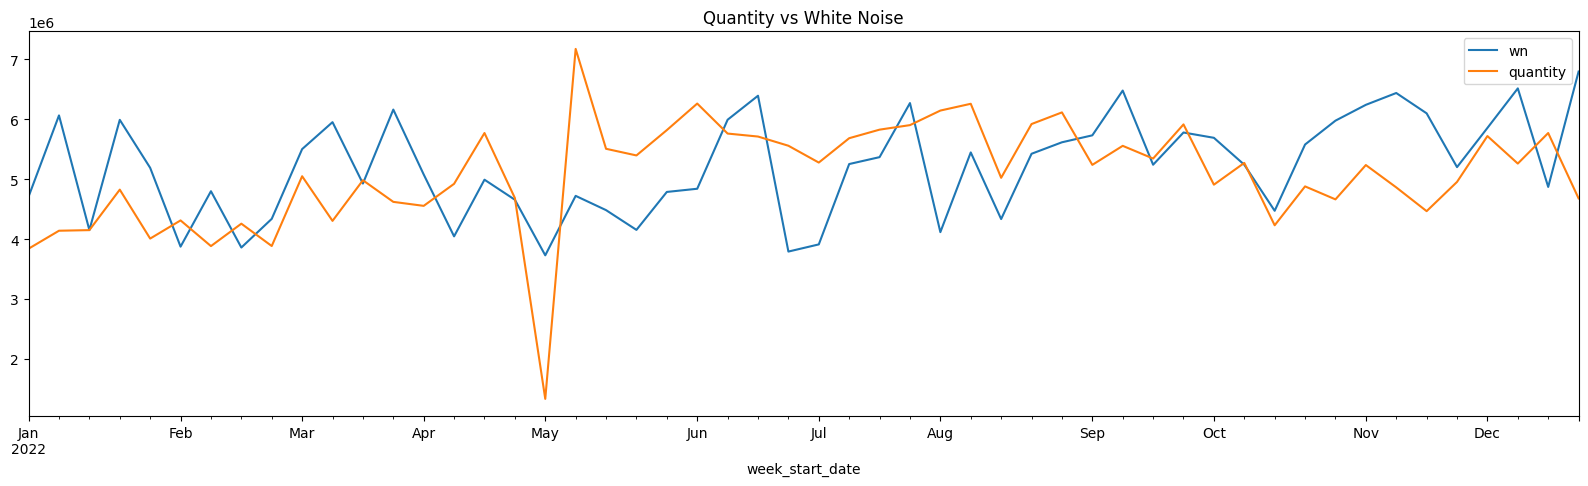

In [198]:
train.wn.plot(figsize = (20,5))
train.quantity.plot()
plt.title('Quantity vs White Noise')
plt.legend()
plt.show()

In [199]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [200]:
check_stationarity(train['quantity'])

ADF Statistic: -5.810232
p-value: 0.000000
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598
Stationary


White Noise dan Stationarity menunjukan bahwa data ini tidak memiliki pattern / trend, dan sepertinya akan susah untuk membuat model yag bisa memprediksi dengan akurat

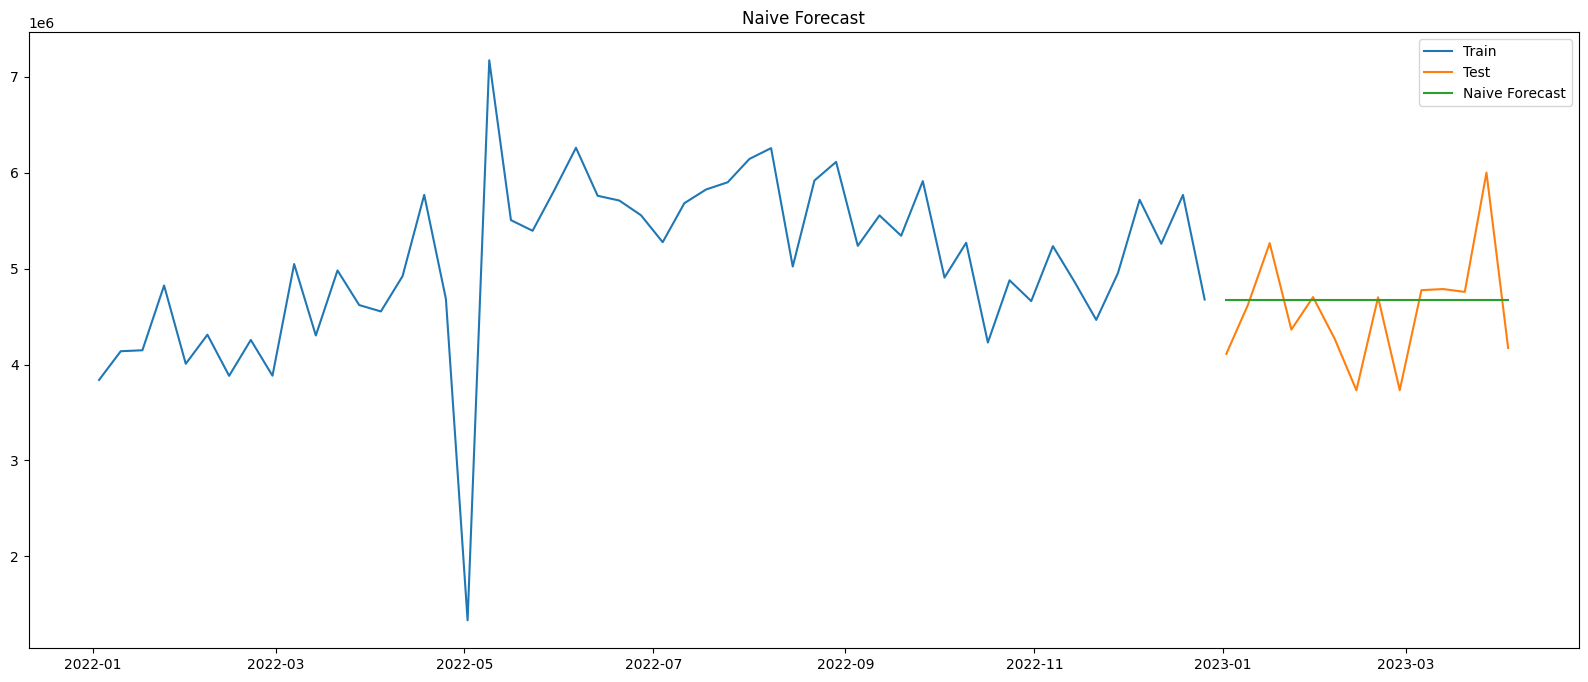

In [201]:
dd= np.asarray(train.quantity)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(20,8))
plt.plot(train.index, train['quantity'], label='Train')
plt.plot(test.index,test['quantity'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [202]:
rmse = sqrt(mean_squared_error(test.quantity, y_hat.naive))
mae = mean_absolute_error(test.quantity, y_hat.naive)

print("mae :",mae)
print("rmse :",rmse)

mae : 427672.5714285714
rmse : 583107.6158442551


In [203]:
train = train.drop(columns=['wn'])


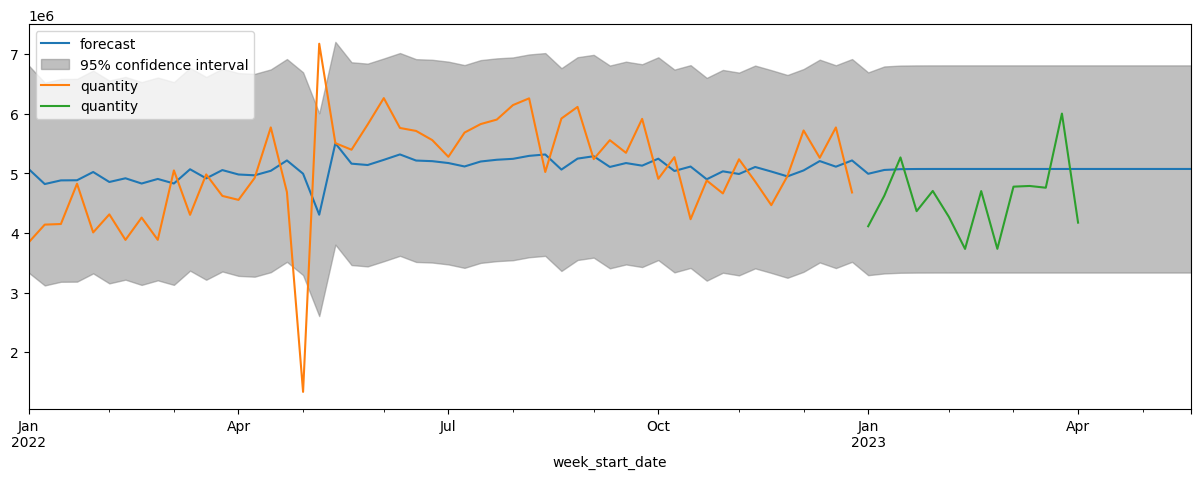

In [204]:
# Autoregressive
mod_ar = ARIMA(train, order=(1,0,0))
res_ar = mod_ar.fit()
fig,ax=plt.subplots(figsize=(15,5))
plot_predict(res_ar, start=0, end=len(train)+20,ax=ax)
train.quantity.plot()
test.quantity.plot()
plt.legend()
plt.show()

In [205]:
# Forecast on test set
forecast_ar = res_ar.forecast(steps=len(test))

# Calculate MAE on test set
mae_ar = mean_absolute_error(test, forecast_ar)

print("MAE for autoregressive model:", mae_ar)

MAE for autoregressive model: 654598.6519882987


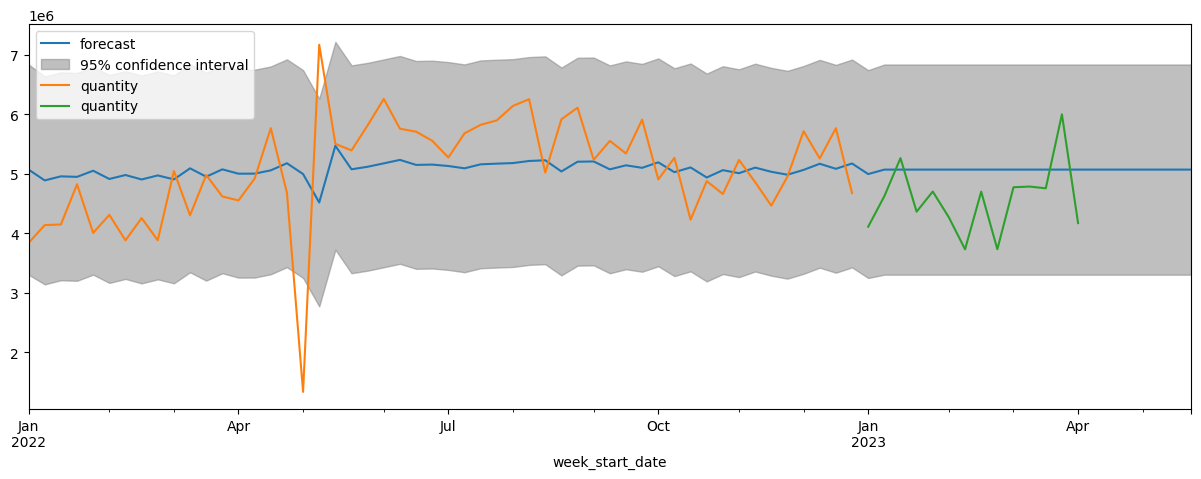

In [206]:
# Moving Average
mod_ma = ARIMA(train, order=(0,0,1))
res_ma = mod_ma.fit()
fig,ax=plt.subplots(figsize=(15,5))
plot_predict(res_ma, start=0, end=len(train)+20,ax=ax)
train.quantity.plot()
test.quantity.plot()
plt.legend()
plt.show()

In [207]:
# Forecast on test set
forecast_ma = res_ma.forecast(steps=len(test))

# Calculate MAE on test set
mae_ma = mean_absolute_error(test, forecast_ma)

print("MAE for Moving Average model:", mae_ma)

MAE for Moving Average model: 656020.6268615326


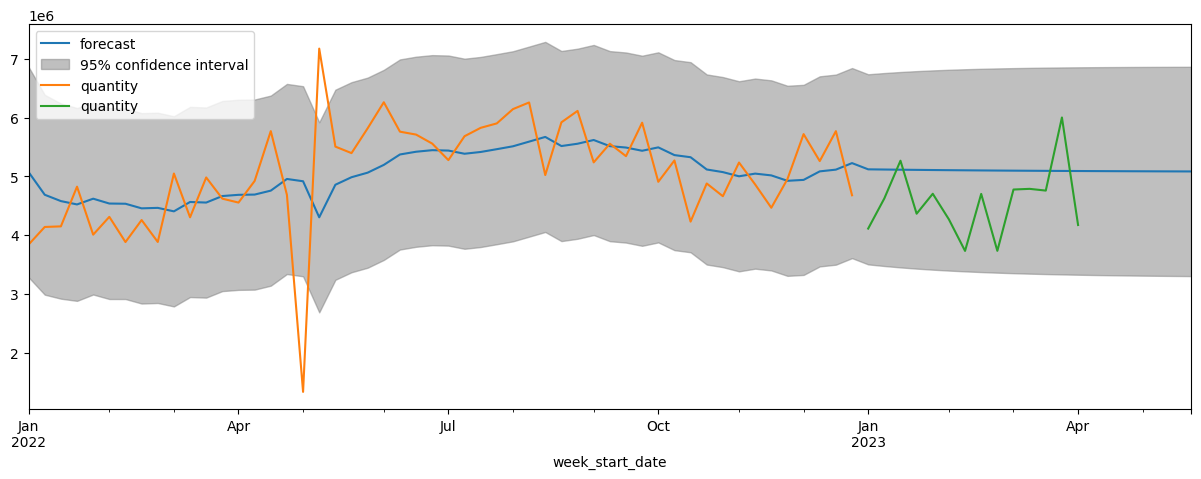

In [208]:
# ARMA
mod_arma = ARIMA(train, order=(1,0,1))
res_arma = mod_arma.fit()
fig,ax=plt.subplots(figsize=(15,5))
plot_predict(res_arma, start=0, end=len(train)+20,ax=ax)
train.quantity.plot()
test.quantity.plot()
plt.legend()
plt.show()

In [209]:
# Forecast on test set
forecast_arma = res_arma.forecast(steps=len(test))

# Calculate MAE on test set
mae_arma = mean_absolute_error(test, forecast_arma)

print("MAE for ARMA model:", mae_arma)

MAE for ARMA model: 683284.7759596886


Kelihatannya AR model paling bisa ngikuting pola nya jadi kita coba improve yang AR model

In [210]:
# Improve with more train data
size = int(len(weekly)*0.9)
train = weekly.iloc[:size]
test = weekly.iloc[size:]

In [211]:
train = train[1:]

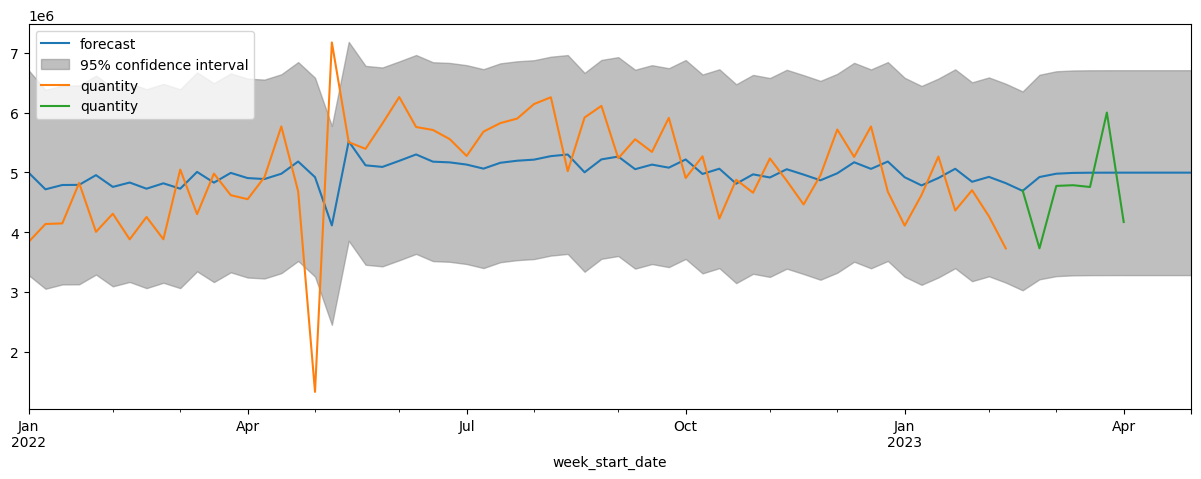

In [212]:
# Autoregressive
mod_ar = ARIMA(train, order=(1,0,0))
res_ar = mod_ar.fit()
fig,ax=plt.subplots(figsize=(15,5))
plot_predict(res_ar, start=0, end=len(train)+10,ax=ax)
train.quantity.plot()
test.quantity.plot()
plt.legend()
plt.show()

In [213]:
# Forecast on test set
forecast_ar_2 = res_ar.forecast(steps=len(test))

# Calculate MAE on test set
mae_ar_2 = mean_absolute_error(test, forecast_ar_2)

print("MAE for improved autoregressive model:", mae_ar_2)

MAE for improved autoregressive model: 525222.7180920586


In [214]:
forecast_ar = res_ar.forecast(steps=5)

# Convert index to quarter-year format
forecast_index = pd.date_range(start=test.index[-1], periods=5, freq='W-Mon')
prediksi = []
for value in forecast_ar:
    prediksi.append('{:.0f}'.format(value))

# Combine index and forecast values into a DataFrame
weekly_df = pd.DataFrame({'Quantity': prediksi}, index=forecast_index)

# Print forecast values
weekly_df

,Quantity
2023-04-03,4692418
2023-04-10,4923680
2023-04-17,4979342
2023-04-24,4992739
2023-05-01,4995964


I will also try to predict the sales quantity for every Quarter in 2023

In [215]:
quarterly = quarterly[1:6]
quarterly

,quantity
week_start_date,
2022-03-31,56246198
2022-06-30,68438232
2022-09-30,74183733
2022-12-31,64885653
2023-03-31,59824088


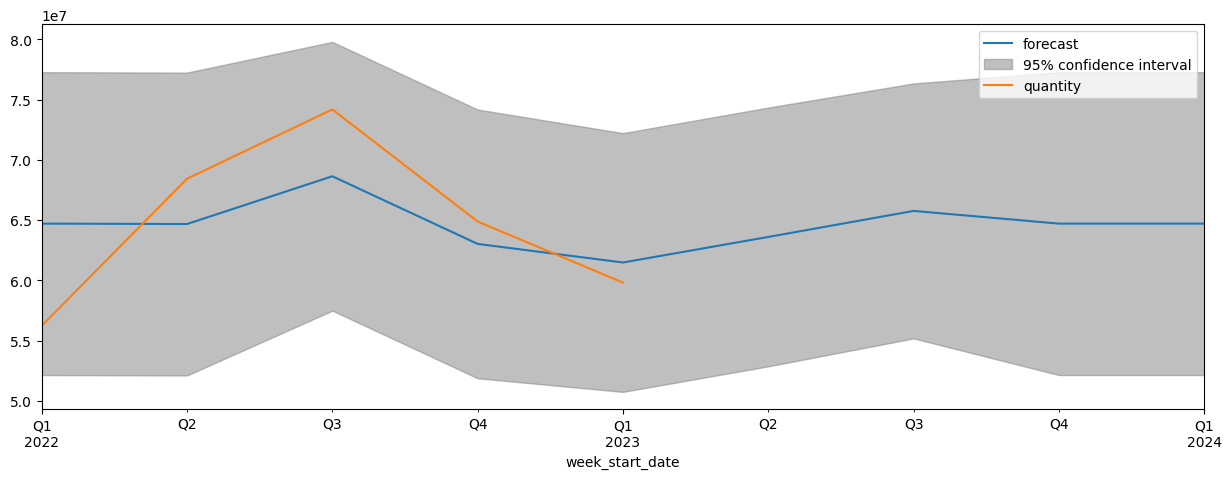

In [216]:
# Moving Average
mod = ARIMA(quarterly, order=(0,0,2))
res = mod.fit()
fig,ax=plt.subplots(figsize=(15,5))
plot_predict(res, start=0, end=len(quarterly)+3,ax=ax)
quarterly.quantity.plot()
plt.legend()
plt.show()

In [217]:
# Forecast on test set
forecast = res.forecast(steps=len(quarterly))

# Calculate MAE on test set
mae = mean_absolute_error(quarterly, forecast)

print("MAE for quarterly model:", mae)

MAE for quarterly model: 4912743.8679840965


In [218]:
forecast = res.forecast(steps=3)

# Convert index to quarter-year format
forecast_index = pd.date_range(start=quarterly.index[-1], periods=3, freq='Q').strftime('Q%q %Y')
hasil = []
for value in forecast:
    hasil.append('{:.0f}'.format(value))

# Combine index and forecast values into a DataFrame
forecast_df = pd.DataFrame({'Quantity': hasil}, index=forecast_index)

# Print forecast values
forecast_df

,Quantity
2023-03-31 00:00:00,63610009
2023-06-30 00:00:00,65768041
2023-09-30 00:00:00,64715581


## 4. Conclusion

1. Salah satu product (id 2949ca4cfbf13969bccfbb9817f2526a) mendominasi sales dengan jumlah terjual 2x lipat dari item kedua sebnayak 18jt
2. Dalam data timeseries penjualan ini data nya Stationary dan mirip dengan White Noise. Hal ini menggambarkan bahwa tidak ada pattern / trend dalam data ini. Maka diasumsikan model akan sulit memprediksi jumlah penjualan dengan akurat
3. Setelah mencoba beberapa model yaitu AR, MA, dan ARMA, melihat dari MAE nya model yang paling bagus adalah model AR

In [219]:
print("MAE for autoregressive model:", mae_ar)
print("MAE for Moving Average model:", mae_ma)
print("MAE for ARMA model:", mae_arma)

MAE for autoregressive model: 654598.6519882987
MAE for Moving Average model: 656020.6268615326
MAE for ARMA model: 683284.7759596886


4. Kita coba improve model dengan menambah jumlah data pada train set dan berhasil improve MAE score by +- 130k

In [220]:
print("MAE for autoregressive model:", mae_ar_2)

MAE for autoregressive model: 525222.7180920586


Berikut hasil forecast model untuk 5 minggu ke depan

In [221]:
weekly_df

,Quantity
2023-04-03,4692418
2023-04-10,4923680
2023-04-17,4979342
2023-04-24,4992739
2023-05-01,4995964


5. Saya juga coba menampilkan dan membuat model berdasarkan data Quarterly yang sebelumnya saya buat di bagian EDA. Berdasarkan hasil plot model terlihat model lebih bisa mengikuti garis data nya, namun sample data masih terlalu sedikit. Berikut hasil forecast penjualan kita selama 2023

In [222]:
forecast_df

,Quantity
2023-03-31 00:00:00,63610009
2023-06-30 00:00:00,65768041
2023-09-30 00:00:00,64715581


Further improvement:
- Menurut saya, model akan bisa lebih memprediksi secara akurat apabila memiliki data yang lebih banyak. Dalam data ini hanya ada data kurang lebih 1 tahun 3 bulan. Jika ada lebih banyak data maka menurut saya model dapat bisa lebih banyak belajar mengenai trend / pattern / seasonality dari data
- Hal tersebut juga berpengaruh untuk data quarterly nya karena dalam data ini hanya ada 5 quarter yang dapat dijadikan sample untuk memprediksi ke depan nya. Dari 5 sample saja, model sudah mulai terbentuk dapat membuat suatu projeksi, alangkah  baik nya jika memiliki lebih banyak sample
- Bisa juga dicoba mengganti pencatatan penjualan dari weekly, menjadi daily / monthly